In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout,Input,BatchNormalization,Concatenate
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,Bidirectional,LSTM
from tensorflow.keras.optimizers import Adam

In [3]:
from tensorflow.keras.models import Model

In [4]:
embedding_path='D:\datasets\glove_twitter_50_100_200\glove.twitter.27B.200d.txt'

In [5]:
x=np.load('padded_train.npy')
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
labels=np.load('hyperpartisan_labels_train.npy',allow_pickle=True)
le=LabelEncoder()
y=le.fit_transform(labels)

In [6]:
import pickle
with open('tokenizer_large.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

vocab_size=len(tokenizer.word_index)+1

max_length=1000

In [7]:
glove_vectors={}
embedding_path='D:\datasets\glove_twitter_50_100_200\glove.twitter.27B.200d.txt'

In [8]:
%%time
file=open(embedding_path,encoding='utf-8')
for line in tqdm(file):
    values=line.split()
    word=values[0]
    vectors=np.asarray(values[1:])
    glove_vectors[word]=vectors

1193514it [00:48, 24399.16it/s]

Wall time: 48.9 s


In [9]:
embedding_matrix=np.zeros((vocab_size,200))
nalist=[]
for word,index in tokenizer.word_index.items():
    vector=glove_vectors.get(word)
    if(vector is not None):
        embedding_matrix[index]=vector
    else:
        nalist.append(word)

In [10]:
def conv1d_BN(max_len, embed_size,embedding_matrix):
 
    filter_sizes = [2, 3, 4, 5, 6]
    num_filters = 128
    inputs = Input(shape=(max_len,), dtype='float32')
    embeds=Embedding(vocab_size,200,input_length=max_length,weights=[embedding_matrix],trainable=False)(inputs)
    
    conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[0]))(embeds)
    act_0 = Activation('relu')(conv_0)
    bn_0 = BatchNormalization(momentum=0.7)(act_0)

    conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]))(embeds)
    act_1 = Activation('relu')(conv_1)
    bn_1 = BatchNormalization(momentum=0.7)(act_1)

    conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[2]))(embeds)
    act_2 = Activation('relu')(conv_2)
    bn_2 = BatchNormalization(momentum=0.7)(act_2)

    conv_3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]))(embeds)
    act_3 = Activation('relu')(conv_3)
    bn_3 = BatchNormalization(momentum=0.7)(act_3)

    conv_4 = Conv1D(num_filters, kernel_size=(filter_sizes[4]))(embeds)
    act_4 = Activation('relu')(conv_4)
    bn_4 = BatchNormalization(momentum=0.7)(act_4)

    maxpool_0 = MaxPooling1D(pool_size=(max_len - filter_sizes[0]))(bn_0)
    maxpool_1 = MaxPooling1D(pool_size=(max_len - filter_sizes[1]))(bn_1)
    maxpool_2 = MaxPooling1D(pool_size=(max_len - filter_sizes[2]))(bn_2)
    maxpool_3 = MaxPooling1D(pool_size=(max_len - filter_sizes[3]))(bn_3)
    maxpool_4 = MaxPooling1D(pool_size=(max_len - filter_sizes[4]))(bn_4)

    concatenated_tensor = Concatenate()([maxpool_0, maxpool_1, maxpool_2, maxpool_3, maxpool_4])
    flatten = Flatten()(concatenated_tensor)
    output = Dense(units=1, activation='sigmoid')(flatten)

    model = Model(inputs=inputs, outputs=output)
    model.summary()
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.001))
    return model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('bn_model_glove_1000.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [13]:
bn_model=conv1d_BN(1000,200,embedding_matrix)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 200)    120791000   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 999, 128)     51328       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 998, 128)     76928       embedding[0][0]                  
______________________________________________________________________________________________

In [17]:
# from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size=0.33, shuffle= True)

In [18]:
# x=None
# y=None

In [14]:
x_val=np.load('padded_test.npy')
y_val=le.transform(np.load('hyperpartisan_labels_test.npy',allow_pickle=True))

In [15]:
history=bn_model.fit(x,y,validation_data=(x_val,y_val),epochs=10,batch_size=128,callbacks=[mc])

Epoch 1/10
4688/4688 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9016
Epoch 00001: val_accuracy improved from -inf to 0.56459, saving model to bn_model_glove_1000.h5
4688/4688 [==============================] - 1096s 234ms/step - loss: 0.2384 - accuracy: 0.9016 - val_loss: 1.0698 - val_accuracy: 0.5646
Epoch 2/10
4688/4688 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9346
Epoch 00002: val_accuracy improved from 0.56459 to 0.56726, saving model to bn_model_glove_1000.h5
4688/4688 [==============================] - 1096s 234ms/step - loss: 0.1582 - accuracy: 0.9346 - val_loss: 1.0723 - val_accuracy: 0.5673
Epoch 3/10
4688/4688 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9469
Epoch 00003: val_accuracy did not improve from 0.56726
4688/4688 [==============================] - 1090s 233ms/step - loss: 0.1312 - accuracy: 0.9469 - val_loss: 1.2708 - val_accuracy: 0.5572
Epoch 4/10
4688/4688 [====================

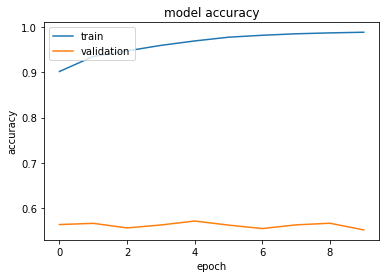

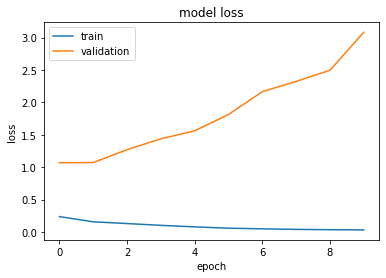

In [16]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
from tensorflow.keras.models import load_model
model=load_model('bn_model_glove_1000.h5')

In [18]:
article_json=r'E:\iiit\Sem3\Information Extraction And Retrieval\major_project\data\json\by_articles.json'

In [19]:
df_article=pd.read_json(article_json).T

In [20]:
encoded_article=tokenizer.texts_to_sequences(df_article['text'].values.tolist())

In [21]:
padded_article=pad_sequences(encoded_article,maxlen=max_length,padding='post')

In [22]:
y_article=le.transform(df_article['hyperpartisan'].values)

In [28]:
article_preds=(model.predict(padded_article)>0.5).astype('int32')

In [30]:
from sklearn.metrics import accuracy_score,f1_score
print(f'Accuracy Score {accuracy_score(y_article,article_preds)}')
print(f'F1 Score {f1_score(y_article,article_preds)}')

Accuracy Score 0.5534883720930233
F1 Score 0.6022099447513812
